# NAVARCH 565 FA 23 Homework 4

Before we start, please put your name and UMID in following format

: Rabia KONUK, #93754692

**Your Answer:**   

# Objectives

This assignment will be more hands-off than the previous perception problems. In the assignment, we will learn about convolutional neural networks and create a U-Net for semantic segmentation of images. You will be free to modify and create your own network. At the end of the assignment, you will generate predictions on a test set and be graded on the mean IoU of your predictions.

# Grading
All points from this assignment will come from evaluation on the test set. We will generate predictions on every tenth frame of the test set for submission to the autograder. This problem is worth 200 points including 50 points of extra credit. Points will be assigned by the mIoU metric as

$$
\text{score} = 200 \frac{\text{mIoU}}{30}
$$

meaning that a score of 30% will obtain all extra credit, and a score of 22.5% will obtain full credit.

# Setup Code
Before getting started we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [35]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Google Colab Setup

Next we need to run a few commands to set up our environment on Google Colab.
Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly then running the folowing cell should print the filenames from the assignment:

```
['UNet.ipynb',  'Problem2.py', 'Labels.txt']
```

In [36]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = "2023FA/A4/UNet"
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

['Problem2.py', 'UNet.ipynb', 'Data', '__pycache__']


Next we have some standard imports

In [37]:
import sys
sys.path.append(GOOGLE_DRIVE_PATH)

import time, os
os.environ["TZ"] = "US/Eastern"
time.tzset()

In [38]:
from Problem2 import *
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm
import numpy as np

Next we will check if a GPU is available

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


# Data Visualization

In this assignment we will be working with camera images and pixel-wise semantic segmentation labels.

First, download the data from https://curly-dataset-public.s3.us-east-2.amazonaws.com/NA565/UNet/StudentData/Student.zip and unzip it to create a Train, Test, and Val folder. Place the files into a Data folder and add the path in the cell below. Move the `Labels.txt` file to Data folder.



Run the cells below to visualize some of the example images from the dataset.

In [58]:
batch_size = 2
DATA_PATH = os.path.join(GOOGLE_DRIVE_PATH, "Data")

trainset = ImageSegmentation(DATA_PATH, "Train", transform=transform_train(), device=device)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, collate_fn=trainset.collate_fn)

valset = ImageSegmentation(DATA_PATH, "Val", transform=transform_test(), device=device)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=True, collate_fn=valset.collate_fn)




Size of the first image in the batch: torch.Size([3, 375, 1242])


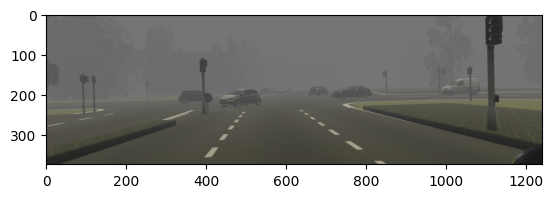

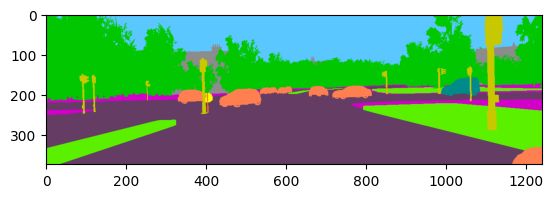

In [42]:
def imshow(img):
    img = img / 2 + 0.5     # un-normalize
    npimg = img.detach().cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def imshow_labels(img):
    npimg = img.detach().cpu().numpy()
    plt.imshow(npimg)
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

first_image_size = images[0].shape
print("Size of the first image in the batch:", first_image_size)

# show images
demo_image = images[0, :, :, :]
imshow(demo_image)

# show labels
demo_label = labels[0, :, :, :]
imshow_labels(demo_label)

Notice how the ground truth is a color-coded image? The cell below takes the colors and converts each color to an integer label for our network to learn.

In [43]:
label_file = open(os.path.join(DATA_PATH, "Labels.txt"), "r")
class_dict = {}

i = 0
label_file.readline()
for line in label_file:
    text = line.split("\n")[0]
    tokens = text.split(" ")
    rgb = np.array([int(tokens[1]), int(tokens[2]), int(tokens[3])])
    class_dict[i] = rgb
    i += 1

# Convert colored image to labels
def to_labels(label_img, color_to_label):
    B, H, W, C = label_img.shape
    labels = torch.zeros((B, H, W, 1), device=label_img.device)
    for i, rgb in color_to_label.items():
        mask = (label_img[:, :, :, 0] == rgb[0]) & (label_img[:, :, :, 1] == rgb[1]) & (label_img[:, :, :, 2] == rgb[2])
        labels[mask] = i
    return labels

## Training

The following cell trains a network on the semantic segmentation data. Copy your `IoU` function from the last assignment into `Problem2.py` so we can judge performance on the IoU score.


We provide a basic starter network `UNetStudent` which you will need to modify to get a full score. Try training the default network once, then making your own modifications to the network.

In [44]:
def train_net_iou(net, trainloader, val_loader, device, num_epochs, optimizer, criterion):
  for epoch in range(num_epochs):  # loop over the dataset multiple times
      # Train
      net.train()
      total_loss = 0
      i = 0
      loop = tqdm(trainloader)
      for data in loop:
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data

          # zero the parameter gradients
          optimizer.zero_grad()

          # Forward pass
          outputs = net(inputs)
          B, C, H, W = outputs.shape
          outputs = outputs.permute(0, 2, 3, 1)
          outputs = outputs.reshape(-1, C)
          labels = to_labels(labels, class_dict)
          labels = labels.long().view(-1)


          # backward + optimize
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          loop.set_description("Training")
          total_loss += loss.detach().item()
          i += 1
          loop.set_postfix(loss=total_loss / i)

      # Validate
      net.eval()
      loop = tqdm(val_loader)
      loop.set_description("Validation")
      with torch.no_grad():
        all_targets = []
        all_preds = []
        for data in loop:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # Forward pass
            outputs = net(inputs)
            B, C, H, W = outputs.shape
            outputs = outputs.permute(0, 2, 3, 1)
            outputs = outputs.reshape(-1, C)
            labels = to_labels(labels, class_dict)
            labels = labels.long().view(-1)

            # Targets and predictions for iou
            _, predicted = torch.max(outputs, 1)
            all_targets.append(labels)
            all_preds.append(predicted)
        all_preds = torch.cat(all_preds)
        all_targets = torch.cat(all_targets)
        iou, miou = IoU(all_targets, all_preds, 15)

        # print statistics
        print(f'epochs: {epoch + 1} mIoU Val: {100 * miou.item():.3f}')
  print('Finished Training')
  return net

In [45]:
num_classes = 15
net = UNetStudent(num_classes).to(device)
# Loss function and optimizer
lr = 0.001
num_epochs = 5
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=1e-5)

# Training the first time will take a while. After the first pass through
# the data, training will speed up.
net = train_net_iou(net, trainloader, val_loader, device, num_epochs, optimizer, criterion)

Validation: 100%|██████████| 125/125 [00:53<00:00,  2.33it/s]


miou:  tensor(0.6334, device='cuda:0')
iou:  tensor([1.0000, 0.6445, 0.8181, 0.8461, 1.0000, 1.0000, 0.6029, 1.0000, 0.1163,
        1.0000, 0.0000, 0.0000, 1.0000, 0.4725, 0.0000], device='cuda:0')
epochs: 1 mIoU Val: 63.336


Validation: 100%|██████████| 125/125 [00:06<00:00, 18.82it/s]


miou:  tensor(0.5536, device='cuda:0')
iou:  tensor([1.0000, 0.5504, 0.5294, 0.7488, 1.0000, 1.0000, 0.3468, 1.0000, 0.0033,
        1.0000, 0.0043, 0.0000, 1.0000, 0.1210, 0.0000], device='cuda:0')
epochs: 2 mIoU Val: 55.360


Validation: 100%|██████████| 125/125 [00:08<00:00, 15.42it/s]


miou:  tensor(0.5736, device='cuda:0')
iou:  tensor([1.0000, 0.5299, 0.6643, 0.7905, 1.0000, 1.0000, 0.4741, 1.0000, 0.0000,
        1.0000, 0.0071, 0.0021, 1.0000, 0.1363, 0.0000], device='cuda:0')
epochs: 3 mIoU Val: 57.362


Validation: 100%|██████████| 125/125 [00:06<00:00, 19.77it/s]


miou:  tensor(0.5996, device='cuda:0')
iou:  tensor([1.0000, 0.2930, 0.5762, 0.7833, 1.0000, 1.0000, 0.4552, 1.0000, 0.1624,
        1.0000, 0.0831, 0.0177, 1.0000, 0.6232, 0.0000], device='cuda:0')
epochs: 4 mIoU Val: 59.961


Validation: 100%|██████████| 125/125 [00:07<00:00, 17.36it/s]


miou:  tensor(0.6181, device='cuda:0')
iou:  tensor([1.0000, 0.6050, 0.6059, 0.8311, 1.0000, 1.0000, 0.6784, 1.0000, 0.0107,
        1.0000, 0.0228, 0.0173, 1.0000, 0.4997, 0.0000], device='cuda:0')
epochs: 5 mIoU Val: 61.806
Finished Training


## Save Weights
Run the next cell to save your weights.

In [48]:
# Save Weights
PATH = os.path.join(DATA_PATH, 'YourNet.pth')
torch.save(net.state_dict(), PATH)

# Visualize predictions
Next, we will load the saved weights and visualize some predictions compared to the ground truth.

In [49]:
net = UNetStudent(num_classes).to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [50]:
# Convert colored image to labels
def label_to_image(label_img, color_to_label):
    B, H, W = label_img.shape
    colored_img = torch.zeros((B, H, W, 3), device=label_img.device, dtype=torch.uint8)
    for i, rgb in color_to_label.items():
        mask = label_img == i
        colored_img[mask, :] = torch.tensor(rgb, device=label_img.device, dtype=torch.uint8)
    return colored_img

Ground Truth


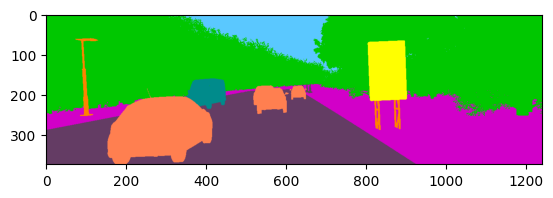

Prediction


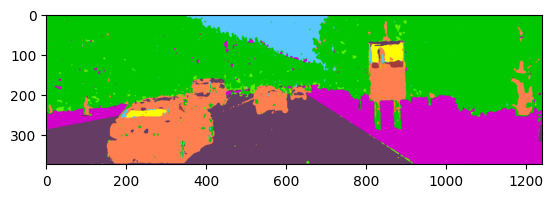

In [51]:
with torch.no_grad():
    # get some random training images
    dataiter = iter(trainloader)
    images, labels = next(dataiter)

    # Make predictions
    # Forward pass
    outputs = net(images)
    B, C, H, W = outputs.shape
    outputs = outputs.permute(0, 2, 3, 1)
    # Targets and predictions for iou
    _, predicted = torch.max(outputs, 3)
    predicted_img = label_to_image(predicted, class_dict)
    # show labels
    print("Ground Truth")
    demo_label = labels[0, :, :, :]
    imshow_labels(demo_label)
    # Show predictions
    print("Prediction")
    demo_pred = predicted_img[0, :, :, :]
    imshow_labels(demo_pred)

## Your Turn
Great! That was an easy assignment so far. Now comes the tricky part though. Now it is your turn to modify the training pipeline, hyper-parameters, and network architecture to improve the performance. Below are some ideas you can try:



1.   Implement image_augmentation with random cropping and flipping.
2.   Add more convolution layers to each level of the U Net.
3.   Change the channel sizes within the U Net.
4.   Change the learning rate, batch size, and number of epochs.
5.   Add weights to the CrossEntropyLoss to weight classes with fewer occurences more.
6.   Modify the training code to save the model weights from the epoch with the highest mIoU on the validation set.
7.   There are many more options... you choose!



In [52]:
num_classes = 15
net = UNetStudent(num_classes).to(device)

# Hyper-parameters
lr = 0.001
num_epochs = 5
batch_size = 2

# Loss function and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=0)
optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=1e-5)

In [53]:
trainset = ImageSegmentation(DATA_PATH, "Train", transform=transform_train(), device=device)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, collate_fn=trainset.collate_fn)

valset = ImageSegmentation(DATA_PATH, "Val", transform=transform_test(), device=device)
val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=True, collate_fn=valset.collate_fn)

In [54]:
net = train_net_iou(net, trainloader, val_loader, device, num_epochs, optimizer, criterion)
torch.save(net.state_dict(), PATH)

  0%|          | 0/170 [00:00<?, ?it/s]/content/drive/My Drive/2023FA/A4/UNet/Problem2.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(img_mat, device=self.device), torch.tensor(label_mat, device=self.device)
Validation: 100%|██████████| 125/125 [00:11<00:00, 10.54it/s]


epochs: 1 mIoU Val: 57.154


Validation: 100%|██████████| 125/125 [00:11<00:00, 10.82it/s]


epochs: 2 mIoU Val: 57.573


Validation: 100%|██████████| 125/125 [00:11<00:00, 10.56it/s]


epochs: 3 mIoU Val: 54.338


Validation: 100%|██████████| 125/125 [00:11<00:00, 10.72it/s]


epochs: 4 mIoU Val: 59.863


Validation: 100%|██████████| 125/125 [00:11<00:00, 10.48it/s]


epochs: 5 mIoU Val: 56.333
Finished Training


When you are happy with your results on the validation set, run the following cells to save the weights and generate predictions on the test set. The entire score from this assignment will be based on the mIoU as described above.

In [55]:
net = UNetStudent(num_classes).to(device)
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [56]:
testset = ImageSegmentation(DATA_PATH, "Test", transform=transform_test(), device=device)

In [57]:
# Test
i = 0
net.eval()
save_dir = os.path.join(DATA_PATH, "Test", "Problem2_Predictions")
if not os.path.exists(save_dir):
  os.mkdir(save_dir)

i = 0
with torch.no_grad():
  for inputs, __ in iter(testset):
    # We are only evaluating every tenth image due to memory constraints on
    # Auto-grader
    if i % 10 == 0:
      C, H, W = inputs.shape
      outputs = net(inputs.view(1, C, H, W).to(device))
      B, C, H, W = outputs.shape
      outputs = outputs.permute(0, 2, 3, 1)
      predictions = outputs.argmax(dim=3).view(H, W)
      predictions_np = predictions.detach().cpu().numpy().astype(np.uint8)
      save_path = os.path.join(save_dir, str(i).zfill(6) + ".label")
      predictions_np.tofile(save_path)
    i += 1

# Submission
Great job! Submit the predictions folder as a zip file called `Problem2_Predictions.zip`, as well as your solution file `Problem2.py` and colab notebook `UNet.ipynb`.